In [37]:
import numpy as np
from scipy import io
#from scipy.stats import zscore
import matplotlib.pyplot as plt

In [20]:
def zscore(X, axis=0):
    mean_X= np.mean(X,axis=axis)
    std_X = np.std(X, axis=axis) + 1e-10
    X -= np.expand_dims(mean_X, axis)
    X /= np.expand_dims(std_X, axis)

    return X

In [39]:
class DataNode():
    def __init__(self, activity_patterns):
        self.n_neurons=activity_patterns.shape[0]
        self.activity_patterns=activity_patterns
        
class SimuNode():
    def __init__(self,n_neurons):
        self.n_neurons=n_neurons
        
class Synapse():
    def __init__(self,pre_synaptic_node, post_synaptic_node):
        self.pre_synaptic_node=pre_synaptic_node
        self.post_synaptic_node=post_synaptic_node
        
    def connect(self):
        row_dim=self.pre_synaptic_node.n_neurons
        col_dim=self.post_synaptic_node.n_neurons
        self.syn_weights=np.random.normal(loc=0,size=(col_dim,row_dim))
        
        
class CodeRunner():
    def __init__(self,connectivity_graph,node_classification):
        self.connectivity_graph=connectivity_graph
        self.node_classification=node_classification
    
    def gain_function(self,x):
        x[x<0]= 5*np.tanh(x[x<0]/5)
        '''
        if x<0:
            return 5*np.tanh(x/5)
        else:
            return (100-5)*np.tanh(x/(100-5))
        '''
        x[x>=0]=(100-5)*np.tanh(x[x>=0]/(100-5))
        return x
        
    def first_sim(self,data_path):
        activity_patterns=zscore(io.loadmat(data_path)['stim'][0]['resp'][0].T,axis=1)
        print(np.mean(activity_patterns,axis=1))
        print(activity_patterns.shape)
        dat=DataNode(activity_patterns)
        sim=SimuNode(1)
        syn=Synapse(dat,sim)
        syn.connect()
        print(syn.syn_weights.shape)
        synapse_lst=[syn]
        
        rate=[0]
        h=0.01
        for t in range(0,100):
            for syn in synapse_lst:
                inpt=syn.syn_weights@activity_patterns[:,t]
                dxdt=(-rate[-1]+self.gain_function(inpt))
                rate.append((rate[-1]+h*dxdt)[0])
                print(inpt)
        print(rate)
        plt.plot(rate)
        
    def second_sim(self,data_path):
        activity_patterns1=io.loadmat(data_path)['stim'][0]['resp'][0].T[:5000,:]
        activity_patterns2=io.loadmat(data_path)['stim'][0]['resp'][0].T[5000:,:]
        node_lst=[]
        for node in self.node_classification:
            if node=='simulated_inh':
                node_lst.append(SimuNode(1))
            if node=='simulated_exc':
                node_lst.append(SimuNode(1))
            if node=='data_inh':
                node_lst.append(DataNode(activity_patterns1))
            if node=='data_exc':
                node_lst.append(DataNode(activity_patterns2))
        synapse_lst=[]
        for row in range(0,self.connectivity_graph.shape[0]):
            for col in range(0,self.connectivity_graph.shape[1]):
                if self.connectivity_graph[row,col]==1:
                    syn=Synapse(node_lst[row],node_lst[col])
                    syn.connect()
                    synapse_lst.append(syn)
                    
        for syn in synapse_lst:
            print(syn.syn_weights.shape)  

[-4.5323137e-08 -8.4980876e-09  4.5323137e-08 ... -5.2876992e-08
 -4.5323137e-08 -1.5107712e-08]
(9479, 4040)
(1, 9479)
[71.40357214]
[-5.]
[-4.99999426]
[56.70273681]
[90.3934912]
[-4.99998115]
[6.06794169]
[71.70846788]
[-5.]
[-5.]
[9.16380074]
[-4.39206254]
[-3.48959276]
[71.97245259]
[82.65930911]
[40.17079434]
[36.07213248]
[18.44114467]
[26.26492642]
[87.59482607]
[63.37058858]
[4.40408137]
[-4.9787635]
[74.32212654]
[-5.]
[23.96952763]
[-5.]
[-4.99999032]
[67.12466768]
[81.92742516]
[-4.98549496]
[72.21585145]
[77.43533496]
[19.43964795]
[-5.]
[-4.98888561]
[2.73768225]
[-4.98178995]
[26.12492574]
[86.56312951]
[37.56563382]
[87.84139945]
[0.0889854]
[91.44306406]
[-4.82124114]
[-3.69491219]
[49.87794095]
[82.57107003]
[49.41464174]
[-3.99136637]
[-4.91118381]
[-5.]
[0.34496191]
[-5.]
[-5.]
[-5.]
[59.61537545]
[10.3498105]
[-4.99816551]
[0.48792599]
[67.99500746]
[7.38052129]
[26.74029349]
[-5.]
[-5.]
[-4.92826634]
[-5.]
[49.84990709]
[72.93785638]
[33.84817129]
[35.15811685]
[-

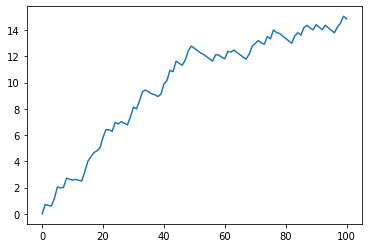

In [40]:
path='/media/maria/DATA1/Documents/old_data/natimg2800_white_M170717_MP034_2017-09-14.mat'
run=CodeRunner(0,0).first_sim(path)

In [30]:
node_classification=['data_exc','data_inh','simulated_exc']
connectivity_graph=np.array([[0,0,1],[0,0,1],[0,0,1]])
run=CodeRunner(connectivity_graph,node_classification).second_sim(path)

(1, 4479)
(1, 5000)
(1, 1)
